In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math as math
from scipy.optimize import minimize
import scipy.stats as ss
from scipy.signal import find_peaks 
from matplotlib import rc
from scipy.optimize import fsolve

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#en figur der fylder en kolonne har bredde 5,8, f.eks: fig, ax= plt.subplots(figsize=(5.8,4))
#en figur der fylder to kolonner har dobbeltbredde??

In [2]:
data = np.transpose(np.loadtxt('Alpha0Cross.txt', skiprows=1))
GV = data[0][:14]
counts = data[1][:14]
countsErr = data[2][:14]
VCharge = data[3][:14]
solid = data[4][:14]
directCounts = data[5][:14]

order = np.argsort(GV)
GV = GV[order]
counts = counts[order]
countsErr = countsErr[order]
VCharge = VCharge[order]
solid = solid[order]
directCounts = directCounts[order]

In [3]:
#target har densitet 2.26g/cm³. Den er 1/3 N15, eller ca. 5/13 = 15/(2*12+15) i masse. dvs N15 har en densitet 
#på 5/13*2.26 g/cm^3

In [4]:
#med 1.57c i NPP
#N_reactions = N_shot * (rho*thickness) * avogrados tal / atomic mass * cross * %rumvinkel
coverage = solid / 4*np.pi
N_shot = VCharge*5.85e7 * 1/0.95 #0.95 fra kalibrering
rt = 5/13 * 2.26e6 * 40e-9 * 6.022*10e23 / 15
cross = counts / (coverage * N_shot * rt) * 1e31
directCross = directCounts / (coverage * N_shot * rt) * 1e31

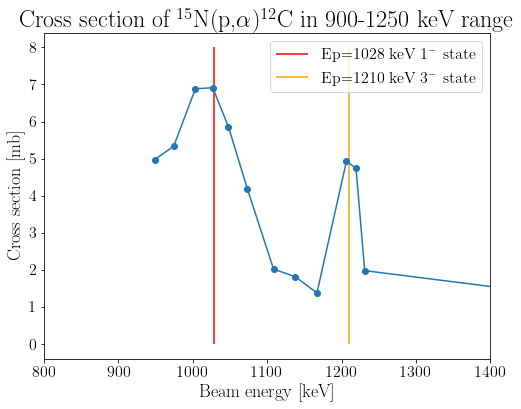

In [5]:
#plt.plot(1.167*GV,cross,'.')
fig, ax = plt.subplots(figsize = [8,6])
ax.set_xlabel('Beam energy [keV]')
ax.plot(1.167*GV,directCross,'-o')
ax.set_xlim(800,1400)
ax.vlines(1028,0,8, label = 'Ep=1028 keV 1$^-$ state', color='red')
ax.vlines(1210,0,8, label = 'Ep=1210 keV 3$^-$ state', color='orange')
ax.set_ylabel('Cross section [mb]')
ax.set_title(r'Cross section of $^{15}$N(p,$\alpha$)$^{12}$C in 900-1250 keV range')
ax.legend()

In [6]:
VCharge*5.85e7

array([1.01128950e+12, 2.75125500e+12, 1.08195750e+13, 4.21527600e+12,
       6.64413750e+12, 3.75692850e+12, 1.55309310e+13, 6.22720800e+12,
       1.32847065e+13, 6.68368350e+12, 9.36690300e+12, 7.30284750e+12,
       8.71474500e+11, 2.02527000e+12])

In [7]:
data = np.transpose(np.loadtxt('angCross1026.txt', skiprows=1))
angles = data[0]
counts = data[1]
countsErr = data[2]
directCounts = data[3]
solid = data[4]
VCharge = data[5]

In [8]:
#med 1.57c i NPP
#N_reactions = N_shot * (rho*thickness) * avogrados tal / atomic mass * cross * %rumvinkel
N_shot = VCharge*5.85e7 * 1/0.95 #0.95 fra kalibrering
rt = 5/13 * 2.26e6 * 40e-9 * 6.022*10e23 / 15
directCross = directCounts / (N_shot * rt * solid) * 1e31

Text(0.5, 1.0, 'Angular cross section at 1026 keV')

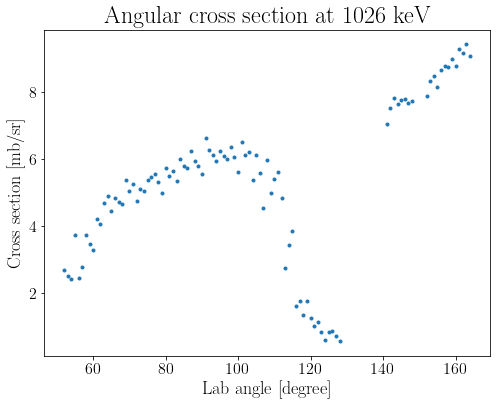

In [9]:
fig, ax = plt.subplots(figsize = [8,6])
ax.set_xlabel('Lab angle [degree]')
ax.plot(angles,directCross,'.')
ax.set_ylabel('Cross section [mb/sr]')
ax.set_title(r'Angular cross section at 1026 keV')

In [10]:
sum(solid)

4.080909999999999

Text(0.5, 1.0, 'Angular cross section at 1206 keV')

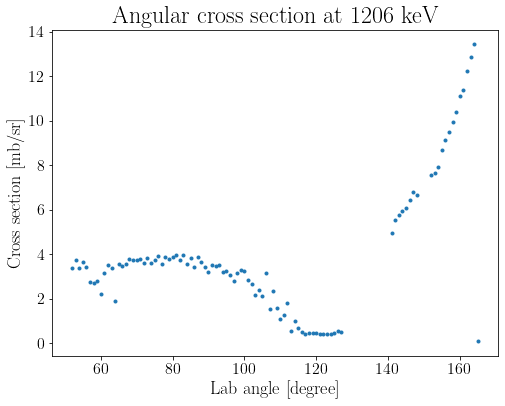

In [11]:
data = np.transpose(np.loadtxt('angCross1206.txt', skiprows=1))
angles = data[0]
counts = data[1]
countsErr = data[2]
directCounts = data[3]
solid = data[4]
VCharge = data[5]
#med 1.57c i NPP
#N_reactions = N_shot * (rho*thickness) * avogrados tal / atomic mass * cross * %rumvinkel
N_shot = VCharge*5.85e7 * 1/0.95 #0.95 fra kalibrering
rt = 5/13 * 2.26e6 * 40e-9 * 6.022*10e23 / 15
directCross = directCounts / (N_shot * rt * solid) * 1e31
fig, ax = plt.subplots(figsize = [8,6])
ax.set_xlabel('Lab angle [degree]')
ax.plot(angles,directCross,'.')
ax.set_ylabel('Cross section [mb/sr]')
ax.set_title(r'Angular cross section at 1206 keV')